# Summary of both works

|   <font size=4>          Topics            |         |<font size=4> MNIST Dataset                 |<font size=4> CIFAR10 Dataset               |
|:------------------------------|---------|:-------------------------------|:------------------------------|
| **Test set accuracy of Keras demos** |         | 98.89% [12 epochs]   | 76.60% [25 epochs]          |
| **Description of my architecture** |        | **ConV (4L) --> [ FC (1Lx512) ] --> SVM**   <br> <font color=blue> Steps for training this model: </font> <br> 1. ConV and FC were trained <br> 2. Extract trained ConV weights and remove FC <br> 3. Train SVM model using flattenned output <br>   from trained ConV as an input. <br><br> Note: accuracy of ConV-->SVM is 99.51%, <br> while ConV-->FC is 99.38% | **ConV (6L) --> FC (1Lx512, 1Lx256)**        |
|** Test set accuracy of my architecture** |        | <font color=red>**99.51%** </font> [9 epochs + SVM]       | <font color=red> **87.53%** </font> [25 epochs]        |
| **Effects of using adaptive learning rate** |        | • No improvement observed compared to ConV --> FC model (93.34%) <br> • Converge 3 epochs later      | • Slightly lower compared to unmodified model (85.2%) <br> • Converge couple epochs earlier.       |
| **Lessons learned** |        |  • Preliminary tests on combinations of loss functions and <br> optimizers showed that a combination of adadelta <br> and catagorical crossentropy yielded the best results. <br> • The introduced exponential learning rate may need to be adjusted for better performance. | • Deep layers of convolutional layers are <br> required to achieve high accuracy. <br> • Higher number of epoch will likely lead to even higher accuracy. <br> • The introduced exponential learning rate may need to be adjusted for better performance.|


*ConV = Convolutional layers, FC = Fully connected layers, SVM = Supported vector machine

# Goal 1: Following example from Keras demo

In [86]:
from __future__ import print_function
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV  
import pickle
import seaborn as sns; sns.set()
import pandas as pd

In [6]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

#fix randomization
np.random.seed(9)

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using TensorFlow backend.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 120s 2ms/step - loss: 0.3305 - acc: 0.8993 - val_loss: 0.0830 - val_acc: 0.9746
Epoch 2/12
60000/60000 [==============================] - 115s 2ms/step - loss: 0.1154 - acc: 0.9653 - val_loss: 0.0542 - val_acc: 0.9834
Epoch 3/12
60000/60000 [==============================] - 116s 2ms/step - loss: 0.0873 - acc: 0.9742 - val_loss: 0.0415 - val_acc: 0.9872
Epoch 4/12
60000/60000 [==============================] - 120s 2ms/step - loss: 0.0734 - acc: 0.9781 - val_loss: 0.0414 - val_acc: 0.9869
Epoch 5/12
60000/60000 [==============================] - 125s 2ms/step - loss: 0.0635 - acc: 0.9812 - val_loss: 0.0343 - val_acc: 0.9885
Epoch 6/12
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0574 - acc: 0.9833 - val_loss: 0.0343 - val_acc: 0.9883
Epoch 7/12
60000/60000 [=========================

# Goal 2: Improving the accuracy beyond the example

Investigating the loss functions and optimizers

In [32]:
def model_1_lossFunc_optimizer(input_shape, num_classes, loss_func, optimizer):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=loss_func,
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

In [37]:
loss_func = ['categorical_crossentropy', 'categorical_hinge', 'mean_squared_logarithmic_error']
optimizer = ['Adam', 'Adadelta', 'RMSprop', 'SGD']
history = {}
keys = []
model_list = {}
for i in range(12):
    keys.append(loss_func[i%3])
    keys[i] += '|+|'
    keys[i] += optimizer[i%4]
    model_list[keys[i]] = model_1_lossFunc_optimizer(input_shape, num_classes, loss_func[i%3], optimizer[i%4])
    
for model in keys:
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)
    print('beginning model {}.'.format(model))
    history[model] = model_list[model].fit(x_train, y_train,
        batch_size=batch_size,
        verbose=2,
        epochs=50,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping])
    score = model_list[model].evaluate(x_test, y_test, verbose=0)
    model_list[model].summary()
    print('model {} ran successfully.'.format(model))

beginning model categorical_crossentropy|+|Adam.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 124s - loss: 0.2398 - acc: 0.9272 - val_loss: 0.0540 - val_acc: 0.9830
Epoch 2/50
 - 122s - loss: 0.0832 - acc: 0.9757 - val_loss: 0.0394 - val_acc: 0.9863
Epoch 3/50
 - 125s - loss: 0.0626 - acc: 0.9811 - val_loss: 0.0311 - val_acc: 0.9898
Epoch 4/50
 - 127s - loss: 0.0524 - acc: 0.9847 - val_loss: 0.0290 - val_acc: 0.9905
Epoch 5/50
 - 128s - loss: 0.0433 - acc: 0.9871 - val_loss: 0.0290 - val_acc: 0.9908
Epoch 6/50
 - 129s - loss: 0.0371 - acc: 0.9883 - val_loss: 0.0305 - val_acc: 0.9902
Epoch 7/50
 - 130s - loss: 0.0356 - acc: 0.9889 - val_loss: 0.0301 - val_acc: 0.9911
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_243 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 24, 24

Epoch 14/50
 - 138s - loss: 0.1681 - acc: 0.9509 - val_loss: 0.0857 - val_acc: 0.9737
Epoch 15/50
 - 138s - loss: 0.1564 - acc: 0.9543 - val_loss: 0.0838 - val_acc: 0.9740
Epoch 16/50
 - 138s - loss: 0.1502 - acc: 0.9552 - val_loss: 0.0768 - val_acc: 0.9768
Epoch 17/50
 - 126s - loss: 0.1438 - acc: 0.9577 - val_loss: 0.0732 - val_acc: 0.9783
Epoch 18/50
 - 127s - loss: 0.1356 - acc: 0.9594 - val_loss: 0.0697 - val_acc: 0.9796
Epoch 19/50
 - 126s - loss: 0.1271 - acc: 0.9620 - val_loss: 0.0665 - val_acc: 0.9793
Epoch 20/50
 - 126s - loss: 0.1259 - acc: 0.9622 - val_loss: 0.0634 - val_acc: 0.9795
Epoch 21/50
 - 128s - loss: 0.1203 - acc: 0.9634 - val_loss: 0.0617 - val_acc: 0.9808
Epoch 22/50
 - 134s - loss: 0.1176 - acc: 0.9652 - val_loss: 0.0592 - val_acc: 0.9822
Epoch 23/50
 - 126s - loss: 0.1138 - acc: 0.9664 - val_loss: 0.0576 - val_acc: 0.9819
Epoch 24/50
 - 127s - loss: 0.1110 - acc: 0.9669 - val_loss: 0.0564 - val_acc: 0.9825
Epoch 25/50
 - 128s - loss: 0.1044 - acc: 0.9689 - val

Epoch 16/50
 - 132s - loss: 0.0020 - acc: 0.9738 - val_loss: 0.0012 - val_acc: 0.9835
Epoch 17/50
 - 132s - loss: 0.0019 - acc: 0.9755 - val_loss: 0.0012 - val_acc: 0.9835
Epoch 18/50
 - 132s - loss: 0.0018 - acc: 0.9770 - val_loss: 0.0011 - val_acc: 0.9842
Epoch 19/50
 - 131s - loss: 0.0017 - acc: 0.9782 - val_loss: 0.0011 - val_acc: 0.9849
Epoch 20/50
 - 132s - loss: 0.0017 - acc: 0.9785 - val_loss: 0.0010 - val_acc: 0.9853
Epoch 21/50
 - 131s - loss: 0.0016 - acc: 0.9792 - val_loss: 0.0010 - val_acc: 0.9851
Epoch 22/50
 - 131s - loss: 0.0016 - acc: 0.9788 - val_loss: 9.9404e-04 - val_acc: 0.9852
Epoch 23/50
 - 131s - loss: 0.0015 - acc: 0.9802 - val_loss: 9.7835e-04 - val_acc: 0.9862
Epoch 24/50
 - 131s - loss: 0.0015 - acc: 0.9809 - val_loss: 9.8443e-04 - val_acc: 0.9862
Epoch 25/50
 - 131s - loss: 0.0015 - acc: 0.9812 - val_loss: 9.7105e-04 - val_acc: 0.9863
Epoch 26/50
 - 131s - loss: 0.0014 - acc: 0.9813 - val_loss: 9.4598e-04 - val_acc: 0.9870
Epoch 27/50
 - 131s - loss: 0.0014

Epoch 32/50
 - 125s - loss: 0.1295 - acc: 0.9368 - val_loss: 0.0779 - val_acc: 0.9630
Epoch 33/50
 - 125s - loss: 0.1254 - acc: 0.9396 - val_loss: 0.0764 - val_acc: 0.9631
Epoch 34/50
 - 124s - loss: 0.1273 - acc: 0.9384 - val_loss: 0.0750 - val_acc: 0.9640
Epoch 35/50
 - 125s - loss: 0.1248 - acc: 0.9399 - val_loss: 0.0773 - val_acc: 0.9623
Epoch 36/50
 - 125s - loss: 0.1211 - acc: 0.9413 - val_loss: 0.0746 - val_acc: 0.9634
Epoch 37/50
 - 125s - loss: 0.1203 - acc: 0.9422 - val_loss: 0.0706 - val_acc: 0.9661
Epoch 38/50
 - 125s - loss: 0.1182 - acc: 0.9430 - val_loss: 0.0714 - val_acc: 0.9652
Epoch 39/50
 - 125s - loss: 0.1173 - acc: 0.9433 - val_loss: 0.0705 - val_acc: 0.9651
Epoch 40/50
 - 125s - loss: 0.1147 - acc: 0.9449 - val_loss: 0.0684 - val_acc: 0.9667
Epoch 41/50
 - 125s - loss: 0.1130 - acc: 0.9454 - val_loss: 0.0661 - val_acc: 0.9685
Epoch 42/50
 - 125s - loss: 0.1129 - acc: 0.9452 - val_loss: 0.0668 - val_acc: 0.9681
Epoch 43/50
 - 126s - loss: 0.1100 - acc: 0.9481 - val

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 130s - loss: 0.2400 - acc: 0.8846 - val_loss: 0.0593 - val_acc: 0.9712
Epoch 2/50
 - 128s - loss: 0.0959 - acc: 0.9540 - val_loss: 0.0432 - val_acc: 0.9788
Epoch 3/50
 - 128s - loss: 0.0788 - acc: 0.9619 - val_loss: 0.0406 - val_acc: 0.9796
Epoch 4/50
 - 127s - loss: 0.0675 - acc: 0.9672 - val_loss: 0.0391 - val_acc: 0.9804
Epoch 5/50
 - 128s - loss: 0.0606 - acc: 0.9704 - val_loss: 0.0319 - val_acc: 0.9840
Epoch 6/50
 - 128s - loss: 0.0565 - acc: 0.9723 - val_loss: 0.0292 - val_acc: 0.9857
Epoch 7/50
 - 127s - loss: 0.0526 - acc: 0.9741 - val_loss: 0.0340 - val_acc: 0.9834
Epoch 8/50
 - 127s - loss: 0.0482 - acc: 0.9764 - val_loss: 0.0284 - val_acc: 0.9861
Epoch 9/50
 - 128s - loss: 0.0467 - acc: 0.9770 - val_loss: 0.0292 - val_acc: 0.9852
Epoch 10/50
 - 128s - loss: 0.0464 - acc: 0.9770 - val_loss: 0.0290 - val_acc: 0.9854
_________________________________________________________________
Layer (type)                 Outp

In [ ]:
for model in keys:
    plt.plot(history[model].history['val_loss'], linewidth=3)
#plt.legend(keys , loc='upper right')
plt.title('val_loss VS epoch')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.grid(color='gray', linestyle='--', linewidth=0.1)
plt.show()

for model in keys:
    plt.plot(history[model].history['val_acc'], linewidth=3)
plt.legend(keys , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('val_acc VS epoch')
plt.ylabel('val_acc')
plt.xlabel('epoch')
plt.grid(color='gray', linestyle='--', linewidth=0.1)
plt.axis([0,50,0.98,1])

plt.show()

From this we can be sure that catagorical_crossentropy with Adadelta optimizer is one of the, if not the, best combinations for this dataset and model. Next step we will vary the model structure to using this loss function and optimizer.

## Training the ConV-->Fully Connected Layers (FC) model with optimized loss functions and optimizer

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
print('Beginning model {}.'.format('model 2'))
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
model_2.add(BatchNormalization(axis=-1))
model_2.add(Conv2D(32, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(BatchNormalization(axis=-1))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(BatchNormalization(axis=-1))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(BatchNormalization(axis=-1))
model_2.add(Dropout(0.10))
model_2.add(Flatten())

model_2.add(Dense(512, activation='relu'))
model_2.add(BatchNormalization(axis=-1))
model_2.add(Dropout(0.35))
#model_2.add(Dropout(0.20))
model_2.add(Dense(num_classes, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
model_2.summary()
history_model2 = model_2.fit(x_train, y_train,
        batch_size=batch_size,
        verbose=2,
        epochs=50,
        validation_data=(x_test, y_test),
        callbacks=[early_stopping])



Beginning model model 2.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 10, 10, 64)    

## Extracting weights and outputs from just the trained ConV

In [65]:
layer_name = 'flatten_2'
intermediate_layer_model = Model(inputs=model_2.input,
                                 outputs=model_2.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train)
intermediate_output_test = intermediate_layer_model.predict(x_test)

### Saving Data

In [7]:
#Saving data
with open( "MNIST.pickle", "wb" ) as file:
    pickle.dump(( intermediate_output, intermediate_output_test), file)
#Loading data
with open( "MNIST.pickle", "rb" ) as file:
    (intermediate_output, intermediate_output_test) = pickle.load(file)

## Using the outputs from ConV for training and optimizing Supported Vector Machine (SVM) 

In [68]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

y_train_digit = np.array([np.argmax(i) for i in y_train])
y_test_digit = np.array([np.argmax(i) for i in y_test])

parameters = {'gamma':[1/2048, 1/1024, 1/512], 'C':[0.5, 1, 2, 5]}
svc = svm.SVC()
clf2 = GridSearchCV(estimator = svc, param_grid = parameters, scoring = 'accuracy')
clf2.fit(intermediate_output, y_train_digit)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.00048828125, 0.0009765625, 0.001953125], 'C': [0.5, 1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

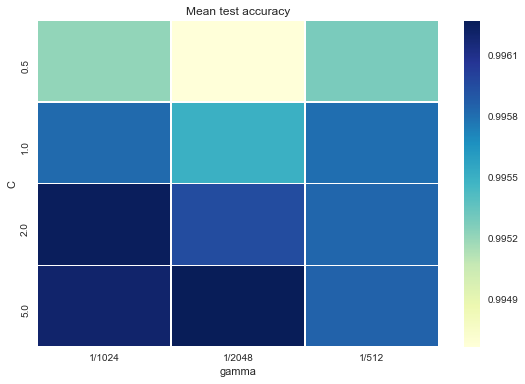

In [69]:
C = np.repeat([0.5, 1, 2, 5],3)
gamma = np.tile(['1/2048', '1/1024', '1/512'],4)

results = pd.DataFrame({'C':C, 'gamma':gamma, 'acc':clf2.cv_results_['mean_test_score']})
results = results.pivot('C', 'gamma', 'acc')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(results, linewidths=.5, ax=ax, cmap="YlGnBu")
plt.title('Mean test accuracy')
plt.show()

In [73]:
y_pred = clf2.predict(intermediate_output_test)
acc = accuracy_score(y_pred, y_test_digit)

## Accuracy of the final model (ConV --> SVM)

In [74]:
acc

0.99509999999999998

# Goal 3: Mofifying the learning rate

In [152]:
# define learning rate function

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        #sd.append(step_decay(len(self.losses)))
        print('       Learning rate: ', K.eval(self.model.optimizer.lr))
        #print('       Loss Check: ', self.losses[-1])


def scheduler(epoch):
    if epoch > 0:
        eta0 = 1.0/np.exp(0.1551) #Using the previous model's initial loss, 1.0 is the default lr vlue for Adadelta.
        eta1 = eta0*np.exp(history.losses[-1])
    else:
        eta1 = 1.0
    return eta1

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
print('Beginning model {}.'.format('model 3'))
model_3 = Sequential()
model_3.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
model_3.add(BatchNormalization(axis=-1))
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(BatchNormalization(axis=-1))
model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(BatchNormalization(axis=-1))
model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(BatchNormalization(axis=-1))
model_3.add(Dropout(0.10))
model_3.add(Flatten())

model_3.add(Dense(512, activation='relu'))
model_3.add(BatchNormalization(axis=-1))
model_3.add(Dropout(0.35))
#model_2.add(Dropout(0.20))
model_3.add(Dense(num_classes, activation='softmax'))
model_3.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
#history_model2 = model_2.fit(x_train, y_train,                                                                                                                                                                                                                                                                           
#        batch_size=batch_size,
#        verbose=2,
#        epochs=50,
#        validation_data=(x_test, y_test),
#        callbacks=[early_stopping])


lrate=LearningRateScheduler(scheduler)   
history = LossHistory()
history_model3 = model_3.fit(x_train, y_train, batch_size=batch_size, epochs=50, verbose=1, \
                             validation_data=(x_test, y_test), callbacks=[history, lrate, early_stopping])

#print(history.losses)

Beginning model model 3.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 188s 3ms/step - loss: 0.1629 - acc: 0.9498 - val_loss: 0.6480 - val_acc: 0.7879
Epoch 2/50
60000/60000 [==============================] - 194s 3ms/step - loss: 0.0471 - acc: 0.9856 - val_loss: 0.0300 - val_acc: 0.9906
Epoch 3/50
60000/60000 [==============================] - 196s 3ms/step - loss: 0.0279 - acc: 0.9914 - val_loss: 0.0260 - val_acc: 0.9910
Epoch 4/50
60000/60000 [==============================] - 197s 3ms/step - loss: 0.0207 - acc: 0.9931 - val_loss: 0.0225 - val_acc: 0.9917
Epoch 5/50
60000/60000 [==============================] - 197s 3ms/step - loss: 0.0140 - acc: 0.9958 - val_loss: 0.0235 - val_acc: 0.9929
Epoch 6/50
60000/60000 [==============================] - 199s 3ms/step - loss: 0.0112 - acc: 0.9967 - val_loss: 0.0229 - val_acc: 0.9932
Epoch 7/50
60000/60000 [==============================] - 200s 3ms/step - loss: 0.0087 - acc: 0.9

In [162]:
# Score trained model.
scores = model_3.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 40s 4ms/step
Test loss: 0.0220352565714
Test accuracy: 0.9934
